In [37]:
import numpy as np
import matplotlib.pyplot as plt 
import healpy as hp

from Qatmosphere_2d import AtmosphereMaps

import yaml

import qubic
from qubic.lib.Instrument.Qacquisition import QubicAcquisition
from qubic.lib.Instrument.Qinstrument import QubicInstrument
from qubic.lib.Qscene import QubicScene
from qubic.lib.Qsamplings import get_pointing

from qubic.scripts.MapMaking.src.FMM.model.planck_timeline import InputMaps

from qubic.lib.MapMaking.Qcg import PCGAlgorithm
from pyoperators.iterative.core import AbnormalStopIteration

from pyoperators import MPI, BlockColumnOperator, BlockDiagonalOperator, DiagonalOperator, ReshapeOperator

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

%matplotlib inline

In [38]:
# Import simulation parameters
with open('params.yml', 'r') as file:
    params = yaml.safe_load(file) 

In [39]:
# Call the class which build the atmosphere maps
atm = AtmosphereMaps(params)
qubic_dict = atm.qubic_dict

(786432, 3)


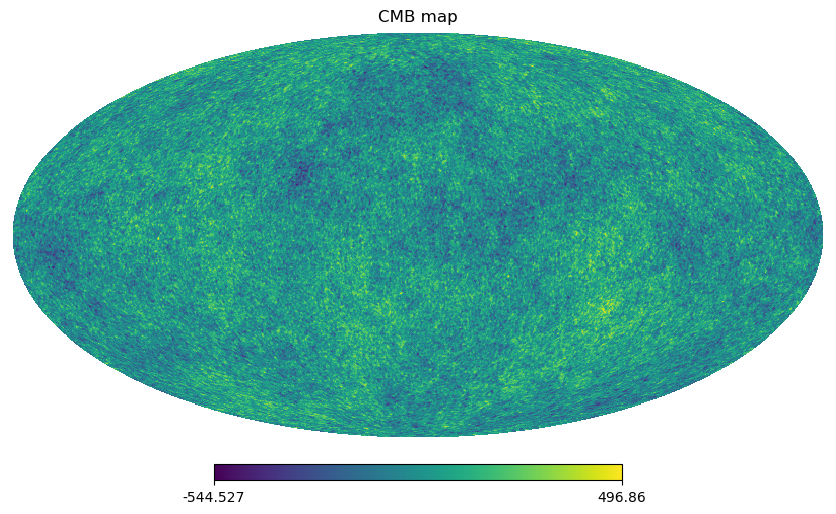

In [40]:
cmb_maps = InputMaps({'cmb':42}, [150e9], 1, params['nside']).m_nu[0]
print(cmb_maps.shape)
hp.mollview(cmb_maps[:, 0], title='CMB map')

786432


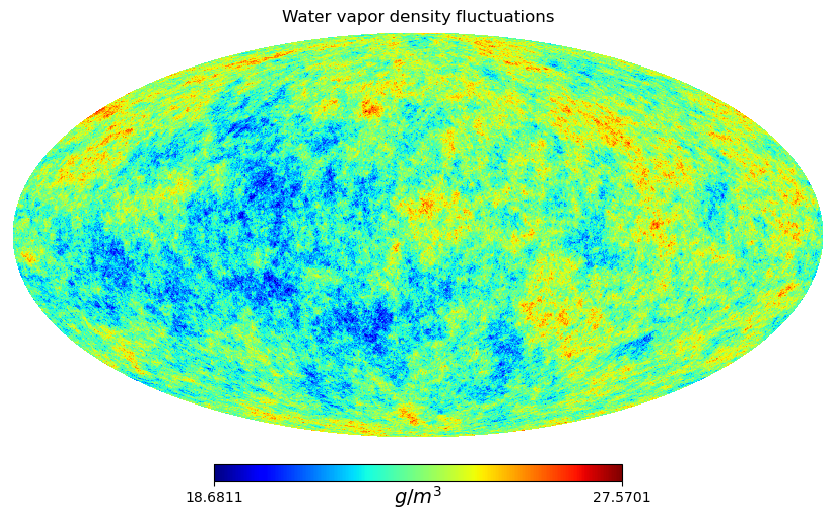

In [41]:
wv_fluctuations = atm.rho_map
print(wv_fluctuations.shape[0])
hp.mollview(wv_fluctuations, cmap='jet', title='Water vapor density fluctuations', unit=r'$g/m^{3}$')

In [42]:
atm.frequencies

array([132.92014967, 136.30295415, 139.77185066, 143.32903024,
       146.97673968, 150.71728296, 154.5530227 , 158.48638163,
       162.51984414, 166.65595787, 194.94955285, 199.91099941,
       204.9987143 , 210.21591101, 215.56588487, 221.05201501,
       226.67776663, 232.44669305, 238.36243807, 244.42873822])

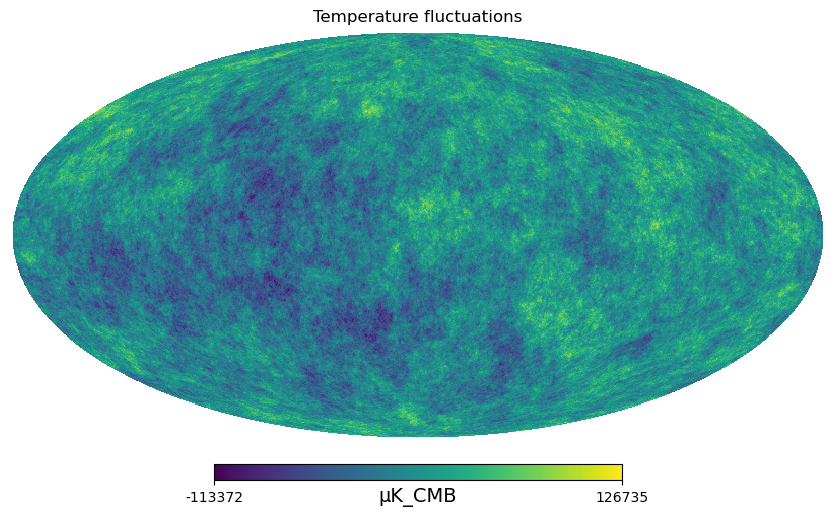

In [43]:
temp_fluctuations = np.zeros((wv_fluctuations.shape[0], 3))
temp_fluctuations[:, 0] = atm.get_temp_maps(wv_fluctuations)[0]
temp_fluctuations[:, 0] -= np.mean(temp_fluctuations[:, 0])

hp.mollview(temp_fluctuations[:, 0], title='Temperature fluctuations', unit='µK_CMB')

In [44]:
q_instrument = QubicInstrument(qubic_dict)
q_sampling = get_pointing(qubic_dict)
q_scene = QubicScene(qubic_dict)

q_acquisition = QubicAcquisition(q_instrument, q_sampling, q_scene, qubic_dict)

You asked 2000 pointings with repeat strategy so I will provide 666 pointings repeated 3 times.


In [45]:
coverage = q_acquisition.get_coverage()

covnorm = coverage / coverage.max()
seenpix = covnorm > params['coverage_cut']

center = np.array([0, -57])
qubic_patch = qubic.lib.Qsamplings.equ2gal(center[0], center[1])

Info apcnb2325: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.


In [46]:
H_qubic = q_acquisition.get_operator()
R_qubic = ReshapeOperator(H_qubic.shapeout, H_qubic.shape[0])
invN_qubic = R_qubic(q_acquisition.get_invntt_operator(False, False)(R_qubic.T))
d_qubic = H_qubic(temp_fluctuations).ravel()

Info apcnb2325: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.


In [47]:
print(temp_fluctuations.shape)
print(cmb_maps.shape)

(786432, 3)
(786432, 3)


In [48]:
H_planck = ReshapeOperator(temp_fluctuations.shape, temp_fluctuations.ravel().shape)
invN_planck = DiagonalOperator(np.ones(H_planck.shapeout))
d_planck = H_planck(temp_fluctuations)

In [49]:
if params['external_data']:
    H = BlockColumnOperator([R_qubic(H_qubic), H_planck], axisout=0)
    invN = BlockDiagonalOperator([invN_qubic, invN_planck], axisout=0)
    d = np.concatenate((d_qubic, d_planck))
else:
    H = R_qubic(H_qubic)
    invN = invN_qubic
    d = d_qubic

In [50]:
A = H.T * invN * H
b = H.T * invN * d.flatten()
x0 = temp_fluctuations*0
true_maps = temp_fluctuations #+ cmb_maps

In [80]:
# Run PCG
algo = PCGAlgorithm(
    A,
    b,
    comm,
    x0=x0,
    tol=1e-10,
    maxiter=2000,
    disp=True,
    M=None,
    center=[0, -57],
    reso=15,
    seenpix=seenpix,
    input=true_maps,
)
try:
    output = algo.run()
    success = True
    message = 'Success'
except AbnormalStopIteration as e:
    output = algo.finalize()
    success = False
    message = str(e)

2
 Iter     Tol      time
   1: nan 0.14939 [nan nan nan ... nan nan nan]
2
   2: nan 0.14004 [nan nan nan ... nan nan nan]
2
   3: nan 0.14061 [nan nan nan ... nan nan nan]
2
   4: nan 0.13737 [nan nan nan ... nan nan nan]
2
   5: nan 0.13987 [nan nan nan ... nan nan nan]
2
   6: nan 0.13833 [nan nan nan ... nan nan nan]
2
   7: nan 0.13966 [nan nan nan ... nan nan nan]
2
   8: nan 0.14022 [nan nan nan ... nan nan nan]
2
   9: nan 0.17145 [nan nan nan ... nan nan nan]
2
  10: nan 0.17529 [nan nan nan ... nan nan nan]
2
  11: nan 0.17233 [nan nan nan ... nan nan nan]
2
  12: nan 0.16960 [nan nan nan ... nan nan nan]
2
  13: nan 0.17296 [nan nan nan ... nan nan nan]
2
  14: nan 0.17200 [nan nan nan ... nan nan nan]
2
  15: nan 0.15657 [nan nan nan ... nan nan nan]
2
  16: nan 0.14681 [nan nan nan ... nan nan nan]
2
  17: nan 0.13847 [nan nan nan ... nan nan nan]
2
  18: nan 0.13944 [nan nan nan ... nan nan nan]
2
  19: nan 0.13809 [nan nan nan ... nan nan nan]
2
  20: nan 0.13722 [nan n

Text(0, 0.5, 'Convergence')

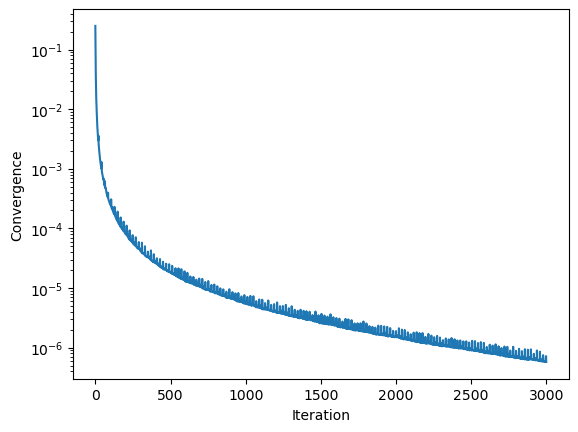

In [52]:
plt.plot(output['convergence'])
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Convergence')

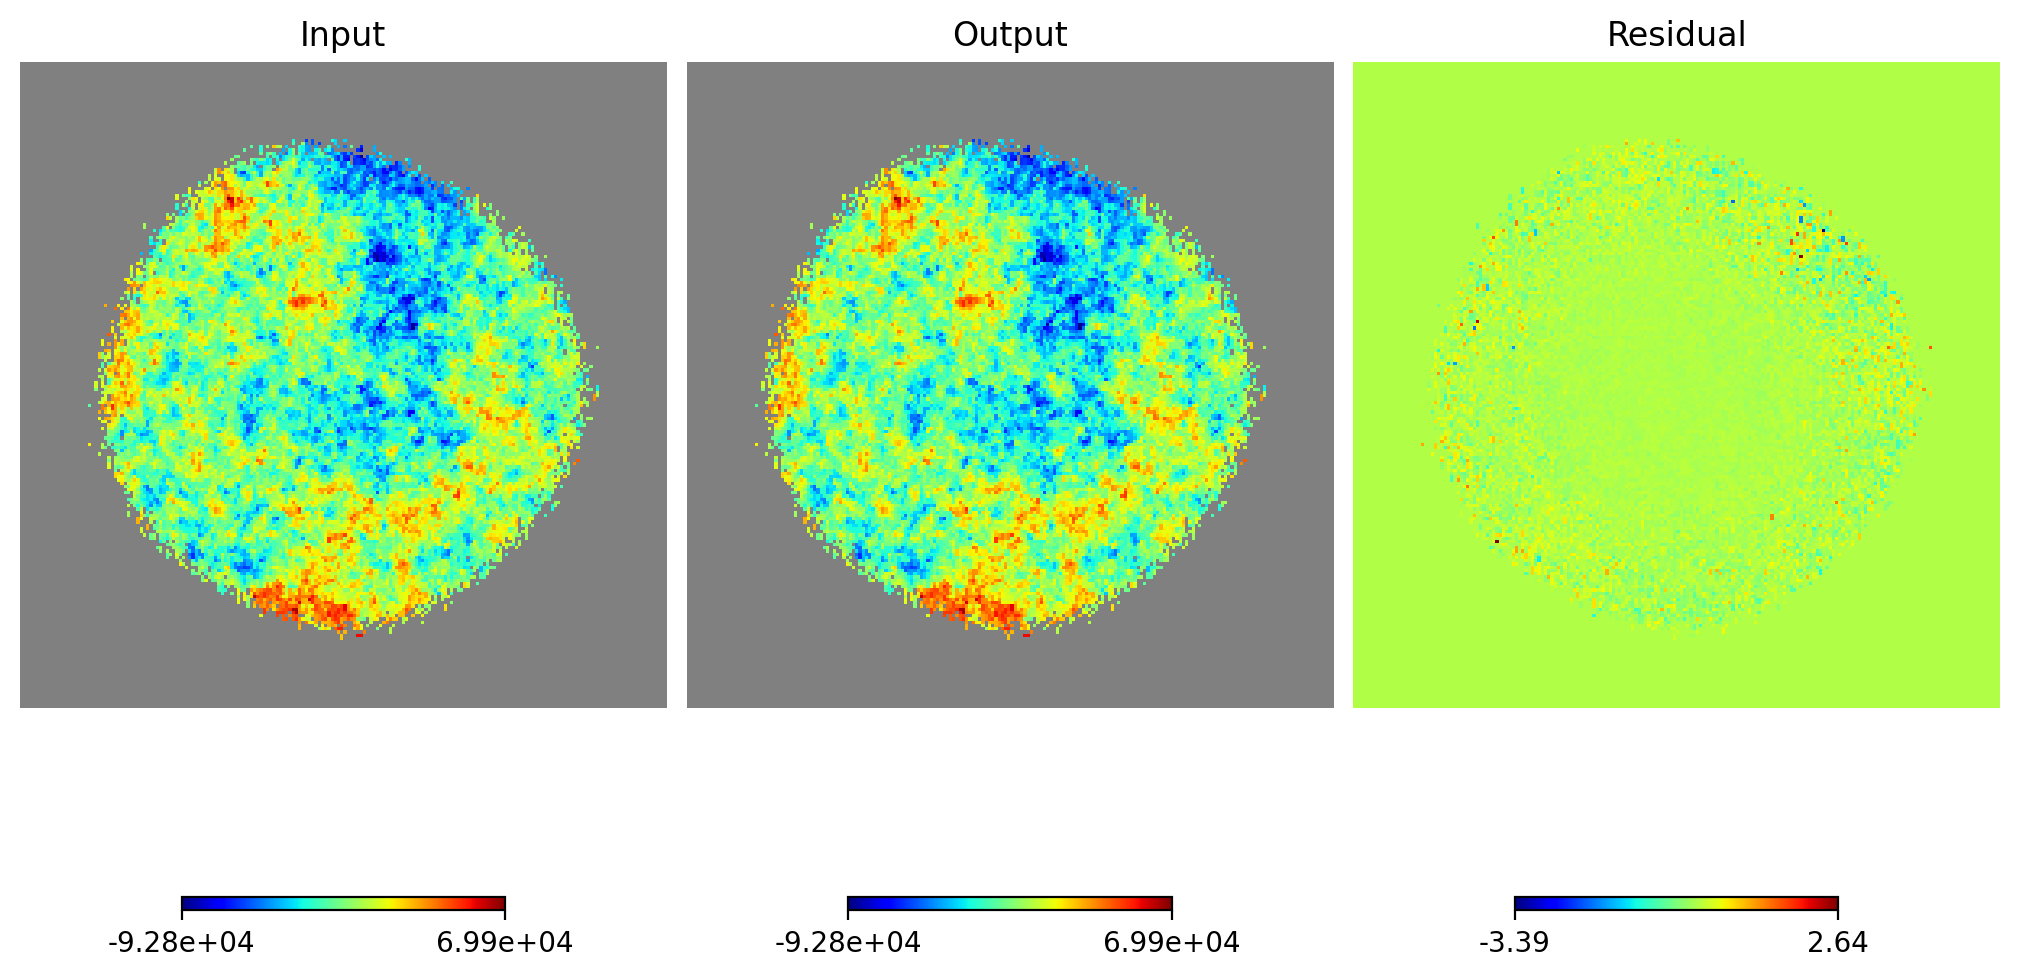

In [53]:
plt.figure(figsize=(10, 12), dpi=200)
k=1
true_maps[~seenpix, :] = hp.UNSEEN
output['x'][~seenpix, :] = hp.UNSEEN

istk = 0
n_sig = 3

sigma = np.std(true_maps[seenpix, istk])
hp.gnomview(true_maps[:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k), title='Input', notext=True)
hp.gnomview(output['x'][:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k+1), title='Output', notext=True)
hp.gnomview(output['x'][:, istk] - true_maps[:, istk], cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k+2), title='Residual', notext=True)
k+=3

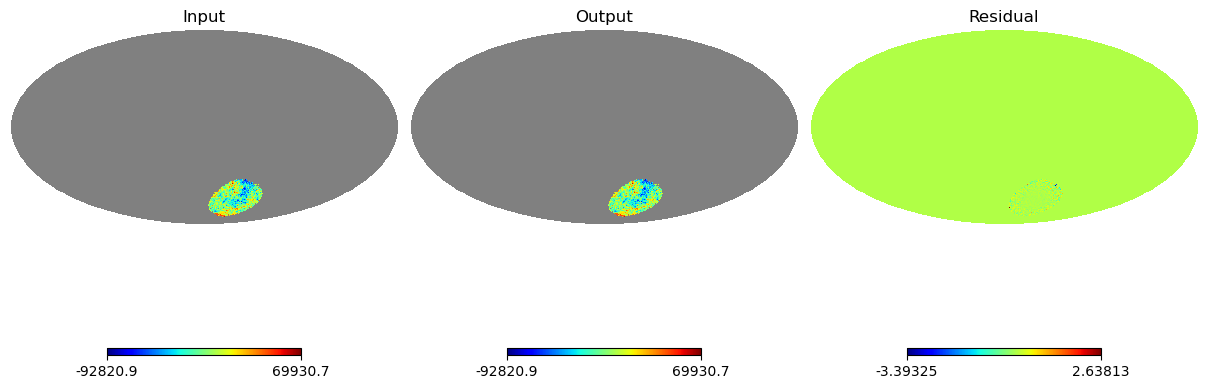

In [54]:
plt.figure(figsize=(12, 25))
k=1
true_maps[~seenpix, :] = hp.UNSEEN
output['x'][~seenpix, :] = hp.UNSEEN

istk = 0
n_sig = 3

sigma = np.std(true_maps[seenpix, istk])
hp.mollview(true_maps[:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', sub=(1, 3, k), title='Input', notext=True)
hp.mollview(output['x'][:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', sub=(1, 3, k+1), title='Output', notext=True)
hp.mollview(output['x'][:, istk] - true_maps[:, istk], cmap='jet', sub=(1, 3, k+2), title='Residual', notext=True)
k+=3

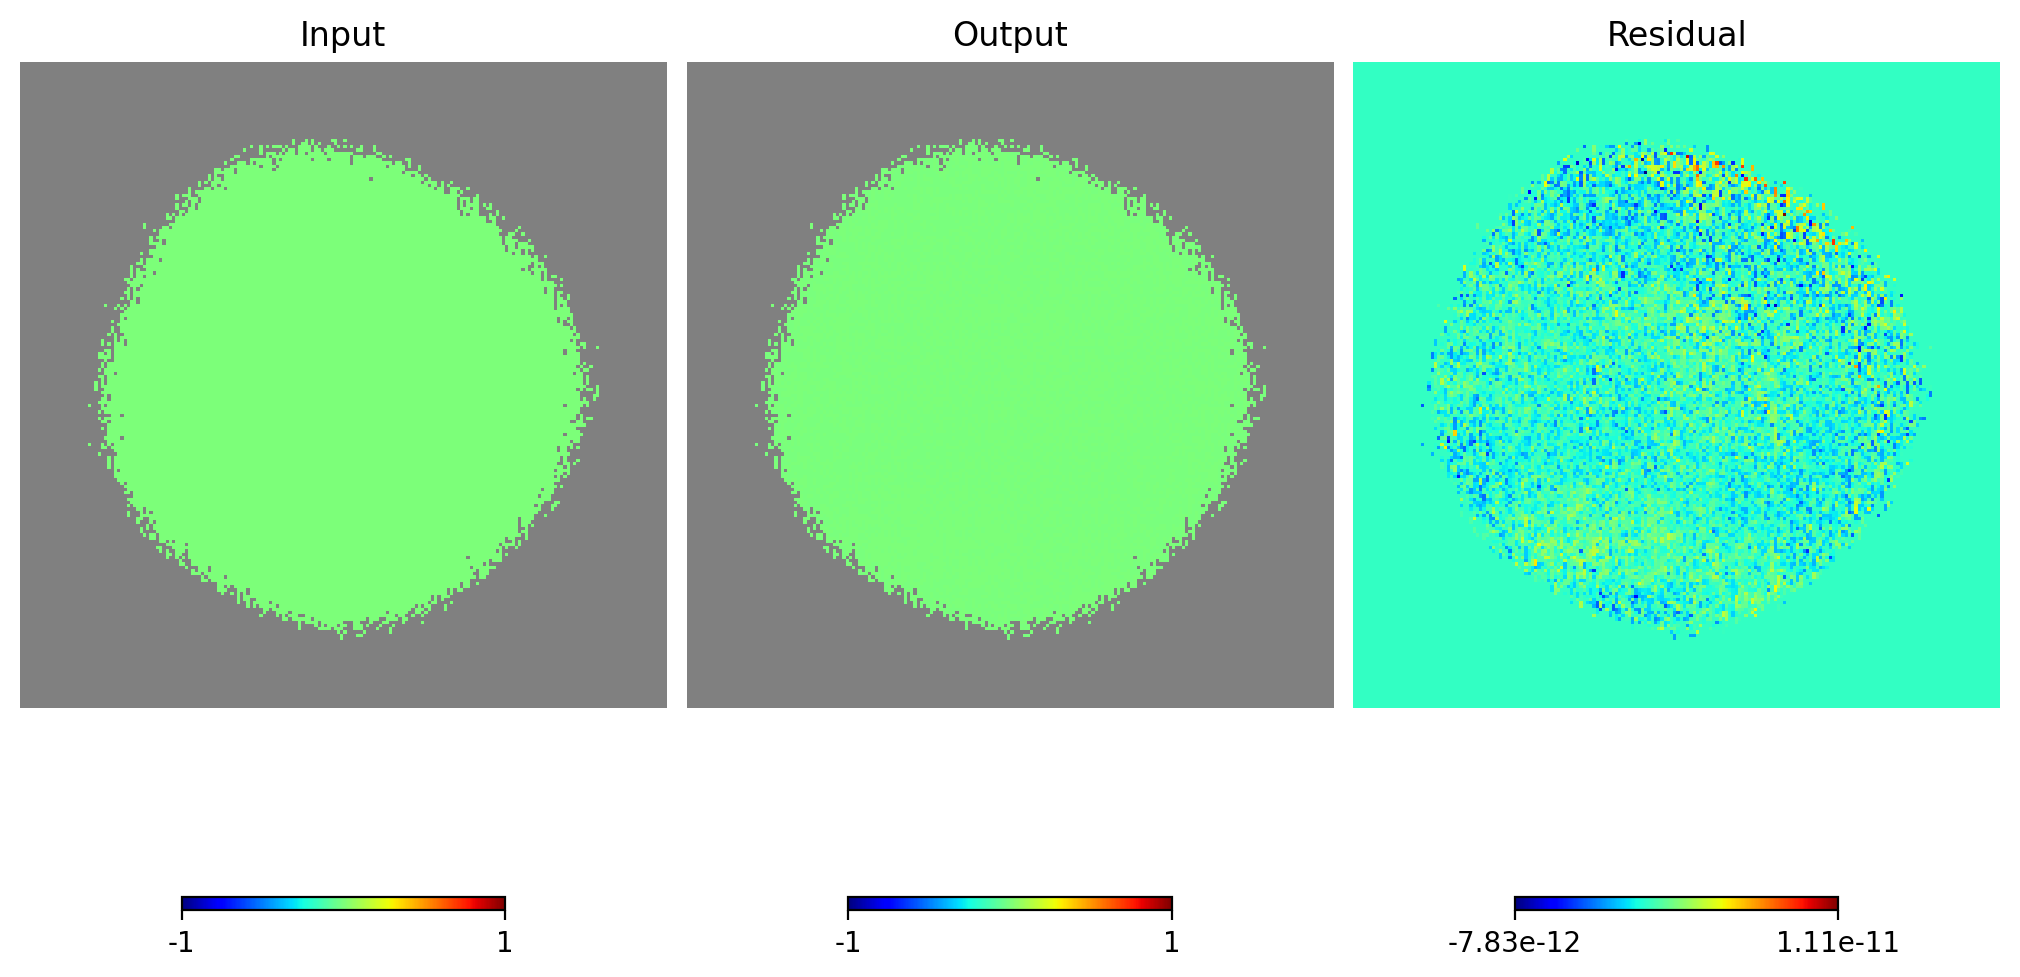

In [55]:
plt.figure(figsize=(10, 12), dpi=200)
k=1
true_maps[~seenpix, :] = hp.UNSEEN
output['x'][~seenpix, :] = hp.UNSEEN

istk = 1
n_sig = 3

sigma = np.std(true_maps[seenpix, istk])
hp.gnomview(true_maps[:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k), title='Input', notext=True)
hp.gnomview(output['x'][:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k+1), title='Output', notext=True)
hp.gnomview(output['x'][:, istk] - true_maps[:, istk], cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k+2), title='Residual', notext=True)
k+=3

In [56]:
npix = hp.nside2npix(128)
test = np.ones(npix)
cl = hp.anafast(test)

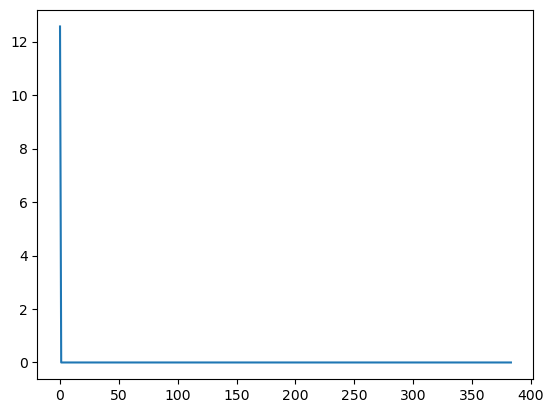

In [57]:
plt.plot(cl)

In [58]:
cl = np.zeros(100)
cl[10] = 1
cl[20] = 1
maps = hp.synfast(cl, 256)

In [59]:
maps.shape

(786432,)

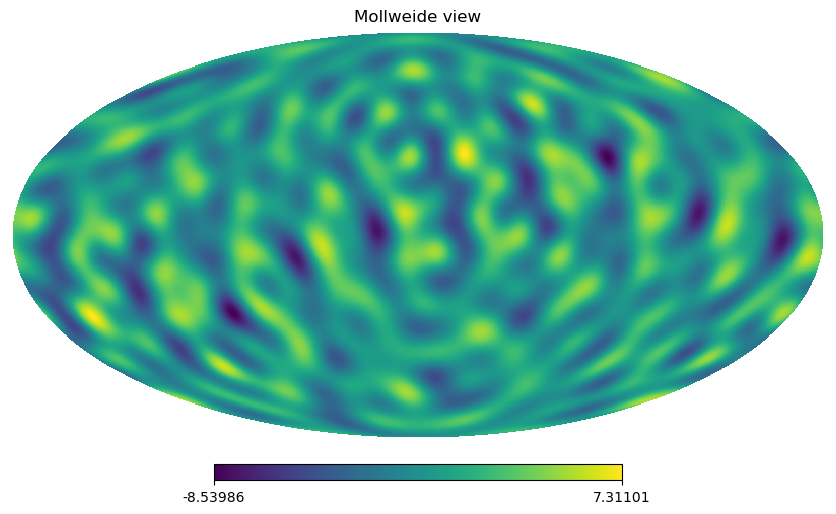

In [60]:
hp.mollview(maps)

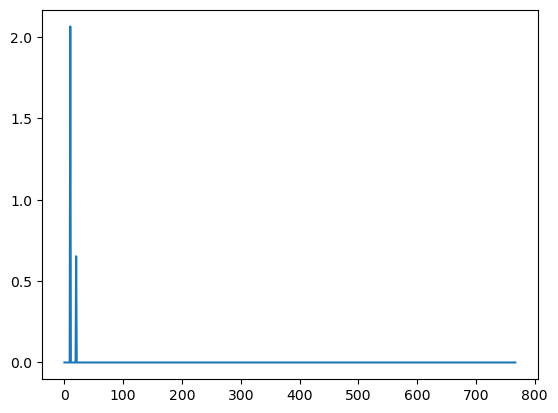

In [61]:
plt.plot(hp.anafast(maps))